In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# gmm
from sklearn.mixture import GaussianMixture
# hdbscan
import hdbscan
# dbscan
from sklearn.cluster import DBSCAN
# kmeans
from sklearn.cluster import KMeans
# os
import os
# pickle
import pickle
# import norm
from scipy.stats import norm
# import Ellipses
from matplotlib.patches import Ellipse

# Check if 'has_changed_directory' is defined
if 'has_changed_directory' not in globals():
    # Change the working directory only if it hasn't been changed before
    os.chdir("..")
    # Set the flag to True after changing the directory
    has_changed_directory = True

In [2]:
# read data/traits_pred_log.csv
df_pred = pd.read_csv('data/traits_pred_log.csv', index_col=0)
# read data/traits_obs_log.csv
df_obs = pd.read_csv('data/traits_obs_log.csv', index_col=0)
# read error_pred_dist.pkl
with open('data/error_pred_dist.pkl', 'rb') as f:
    error_pred_dist = pickle.load(f)
# read data/gymnosperms.csv
df_gymno = pd.read_csv('data/gymnosperms.csv', index_col=0)

df_gymno_pred = df_pred[df_pred.index.isin(df_gymno['accepted_bin'])]
df_gymno_obs = df_obs[df_obs.index.isin(df_gymno['accepted_bin'])]

In [3]:
# normalize error
for trait in df_gymno_pred.columns:
    error_pred_dist[trait] = (error_pred_dist[trait] - df_gymno_pred[trait].mean()) / df_gymno_pred[trait].std()
    df_gymno_pred[trait] = (df_gymno_pred[trait] - df_gymno_pred[trait].mean()) / df_gymno_pred[trait].std()

# normalize the data
# df_gymno_pred_norm = (df_gymno_pred - df_gymno_pred.mean()) / df_gymno_pred.std()


C:\Users\pablo\AppData\Local\Temp\ipykernel_28280\23683145.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gymno_pred[trait] = (df_gymno_pred[trait] - df_gymno_pred[trait].mean()) / df_gymno_pred[trait].std()


# 1 Dimensional Case - Crown Height

In [4]:
def resample_trait(X, error_list, weight = 1):
    sampled_error = np.random.choice(error_list, size=X.shape, replace=True)*weight
    return X + sampled_error

C:\Users\pablo\AppData\Local\Temp\ipykernel_28280\1665791637.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gymno_pred[trait_resampled] = df_gymno_pred[trait] + sampled_error


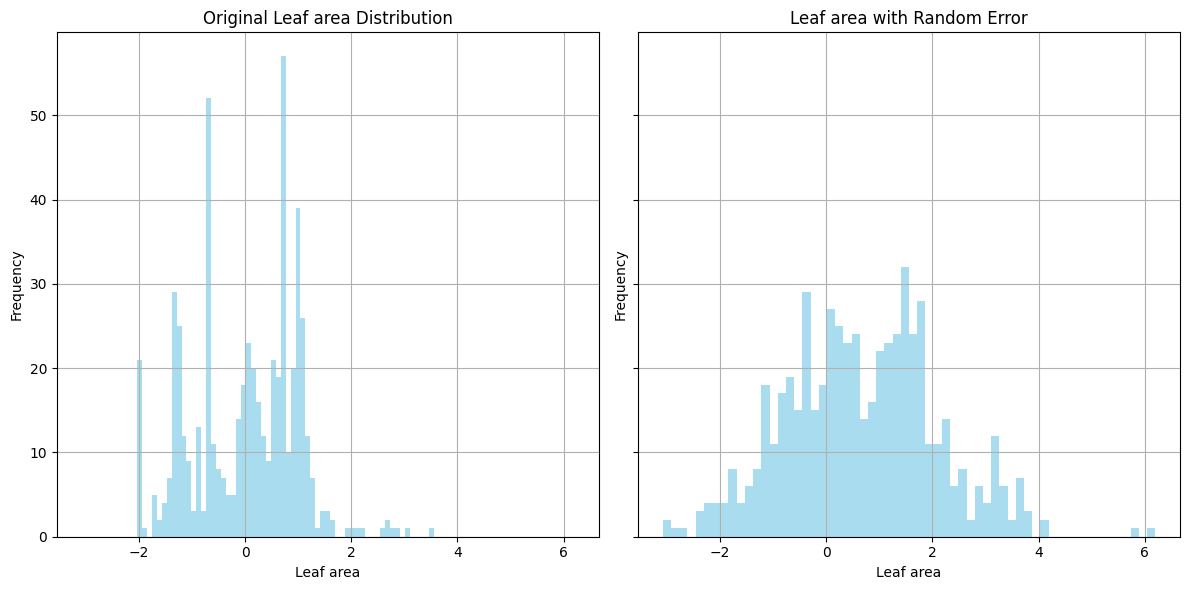

In [5]:
trait = 'Leaf area'
trait_resampled = f'{trait} resampled'

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)  # 1 row, 2 columns

# Histogram of original 'Crown height'
df_gymno_pred[trait].hist(bins=60, ax=axs[0], color='skyblue', alpha=0.7)
axs[0].set_title(f'Original {trait} Distribution')
axs[0].set_xlabel(trait)
axs[0].set_ylabel('Frequency')

# Sample random error from the error prediction distribution
sampled_error = np.random.choice(error_pred_dist['gymnosperm'][trait], len(df_gymno_pred),
                                 replace=True)

# Add random error to trait
df_gymno_pred[trait_resampled] = df_gymno_pred[trait] + sampled_error

# Replace values in observed index with observed trait (uncomment if needed)
# df_gymno_pred.loc[df_gymno_obs.index, 'trait_resampled'] = df_gymno_obs[trait]

# Histogram of 'trait_resampled'
df_gymno_pred[trait_resampled].hist(bins=60, ax=axs[1], color='skyblue', alpha=0.7)
axs[1].set_title(f'{trait} with Random Error')
axs[1].set_xlabel(trait)
axs[1].set_ylabel('Frequency')

# Show the plots
plt.tight_layout()  # Adjust the layout to make room for the titles and labels
plt.show()

In [6]:
def best_gmm_bic(df_data, n_components_list):
    """Evaluate Gaussian Mixture Models for varying number of components and return the best based on BIC."""
    best_bic = np.inf
    best_n = None
    for n_components in n_components_list:
        gmm = GaussianMixture(n_components=n_components, random_state = 123, n_init=3)
        gmm.fit(df_data)
        bic = gmm.bic(df_data)
        if bic < best_bic:
            best_bic = bic
            best_n = n_components
    return best_n, best_bic



In [7]:
# Assuming df_gymno_pred contains 'Crown height' and 'Crown height resampled' columns
best_n, best_bic = best_gmm_bic(df_gymno_pred[[trait]], range(1, 15))
best_n_resampled, best_bic_resampled = best_gmm_bic(df_gymno_pred[[trait_resampled]], range(1, 15))

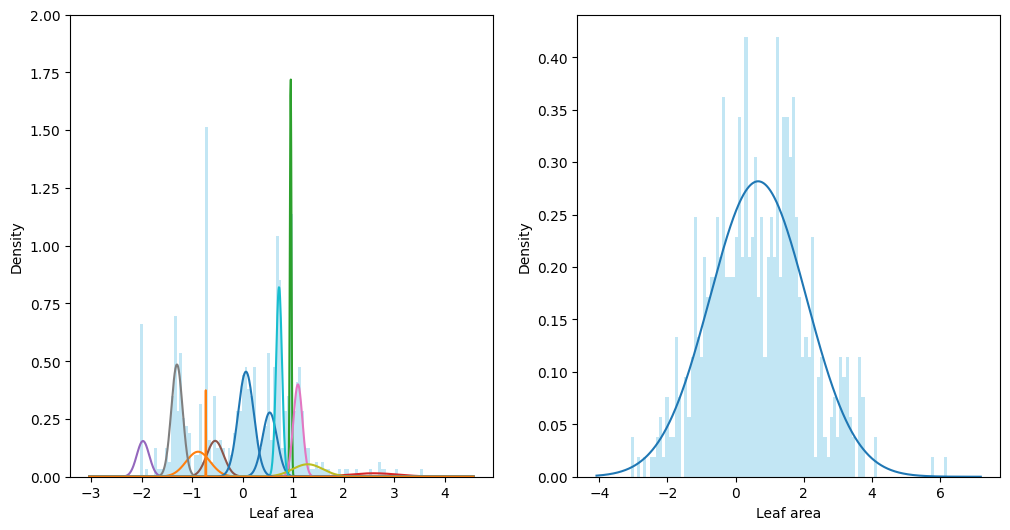

In [8]:
# create figure to show both histograms
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(df_gymno_pred[trait], bins=100, color='skyblue', alpha=0.5, label='Original',
           density=True)
gmm_original = GaussianMixture(n_components=best_n, random_state=123, n_init=10)
gmm_original.fit(df_gymno_pred[[trait]])
x = np.linspace(df_gymno_pred[trait].min()-1, df_gymno_pred[trait].max()+1, 1000)
for mean, cov, weight in zip(gmm_original.means_.flatten(), gmm_original.covariances_.flatten(), gmm_original.weights_):
    pdf = norm.pdf(x, mean, np.sqrt(cov)) * weight
    ax[0].plot(x, pdf, label=f'μ: {mean:.2f}, σ: {cov:.2f}, π: {weight:.2f}')
# set max for y axis
ax[0].set_ylim(0, 2)


ax[1].hist(df_gymno_pred[trait_resampled], bins=100, color='skyblue', alpha=0.5, label='Resampled',
           density=True)
gmm_resampled = GaussianMixture(n_components=best_n_resampled, random_state=123, n_init=10)
gmm_resampled.fit(df_gymno_pred[[trait_resampled]])
x = np.linspace(df_gymno_pred[trait_resampled].min()-1, df_gymno_pred[trait_resampled].max()+1, 1000)
for mean, cov, weight in zip(gmm_resampled.means_.flatten(), gmm_resampled.covariances_.flatten(), gmm_resampled.weights_):
    pdf = norm.pdf(x, mean, np.sqrt(cov)) * weight
    ax[1].plot(x, pdf, label=f'μ: {mean:.2f}, σ: {cov:.2f}, π: {weight:.2f}')

# axis label
ax[0].set_xlabel(trait)
ax[0].set_ylabel('Density')
ax[1].set_xlabel(trait)
ax[1].set_ylabel('Density')

plt.show()

C:\Users\pablo\AppData\Local\Temp\ipykernel_28280\3603747907.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_original = plt.cm.get_cmap('Set2', len(unique_clusters_original))
C:\Users\pablo\AppData\Local\Temp\ipykernel_28280\3603747907.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_resampled = plt.cm.get_cmap('Set2', len(unique_clusters_resampled))


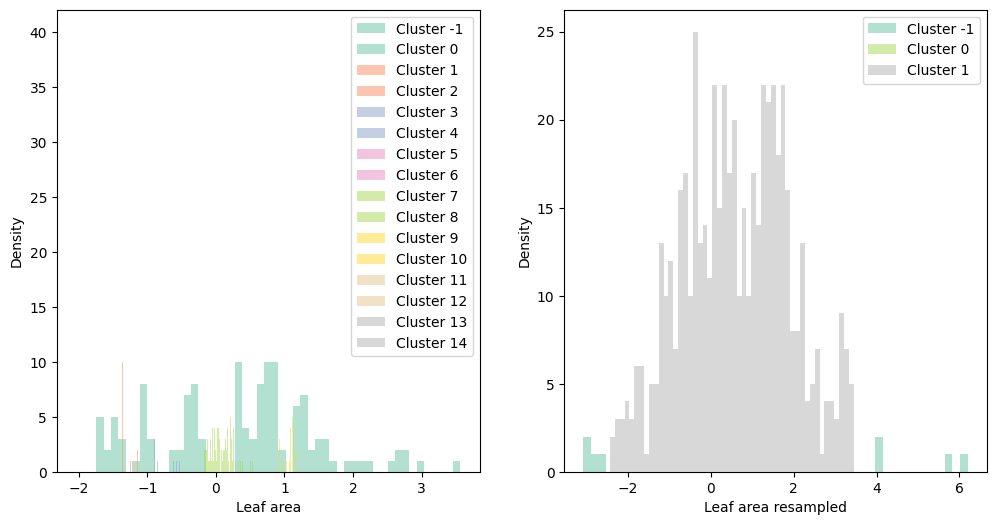

In [9]:

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# HDBSCAN on original data
hdbscan_original = hdbscan.HDBSCAN(min_cluster_size=10)
clusters_original = hdbscan_original.fit_predict(np.array(df_gymno_pred[trait]).reshape(-1, 1))
unique_clusters_original = np.unique(clusters_original)
colors_original = plt.cm.get_cmap('Set2', len(unique_clusters_original))
for i, cluster in enumerate(unique_clusters_original):
    mask = clusters_original == cluster
    ax[0].hist(np.array(df_gymno_pred[trait])[mask], bins=50, color=colors_original(i),
               alpha=0.5, label=f'Cluster {cluster}')
ax[0].set_xlabel(trait)
ax[0].set_ylabel('Density')
ax[0].legend()

# HDBSCAN on resampled data
hdbscan_resampled = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=1, cluster_selection_epsilon=0.5)
clusters_resampled = hdbscan_resampled.fit_predict(np.array(df_gymno_pred[trait_resampled]).reshape(-1, 1))
unique_clusters_resampled = np.unique(clusters_resampled)
colors_resampled = plt.cm.get_cmap('Set2', len(unique_clusters_resampled))
for i, cluster in enumerate(unique_clusters_resampled):
    mask = clusters_resampled == cluster
    ax[1].hist(np.array(df_gymno_pred[trait_resampled])[mask], bins=50, color=colors_resampled(i),
               alpha=0.5, label=f'Cluster {cluster}')
ax[1].set_xlabel(trait_resampled)
ax[1].set_ylabel('Density')
ax[1].legend()

plt.show()

In [10]:
### RESAMPLING APPROACH ####

consensus_matrix = np.zeros((df_gymno_pred.shape[0], df_gymno_pred.shape[0]))

for i in range(100):
    error_list = error_pred_dist['gymnosperm'][trait]
    df_gymno_pred.loc[:,trait_resampled] = resample_trait(df_gymno_pred[trait], error_list)
    # fit HDBSCAN and get labels
    hdbscan_resampled = hdbscan.HDBSCAN(min_cluster_size=10)
    clusters_resampled = hdbscan_resampled.fit_predict(np.array(df_gymno_pred[trait_resampled]).reshape(-1, 1))
    # add to consensus matrix
    for j in range(df_gymno_pred.shape[0]):
        for k in range(j+1, df_gymno_pred.shape[0]):
            if clusters_resampled[j] == clusters_resampled[k]:
                consensus_matrix[j, k] += 1
                consensus_matrix[k, j] += 1

# normalize consensus matrix
consensus_matrix = consensus_matrix / 100

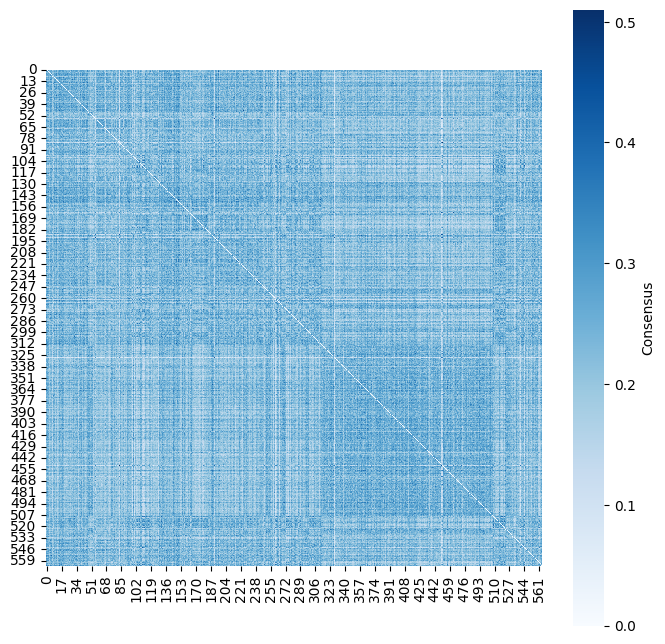

In [11]:
# plot consensus matrix as heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(consensus_matrix, cmap='Blues', square=True, cbar_kws={'label': 'Consensus'})
plt.show()

In [12]:
### RESAMPLING APPROACH ####
trait1 = 'Leaf area'
trait2 = 'Wood density'
trait_resampled1 = f'{trait1} resampled'
trait_resampled2 = f'{trait2} resampled'

consensus_matrix = np.zeros((df_gymno_pred.shape[0], df_gymno_pred.shape[0]))

for i in range(20):
    error_list1 = np.array(error_pred_dist['gymnosperm'][trait])
    error_list2 = np.array(error_pred_dist['gymnosperm'][trait2])
    df_gymno_pred.loc[:,trait_resampled1] = resample_trait(df_gymno_pred[trait1], error_list1)
    df_gymno_pred.loc[:,trait_resampled2] = resample_trait(df_gymno_pred[trait2], error_list2)

    # fit GMM and get labels
    best_n_resampled, best_bic_resampled = best_gmm_bic(df_gymno_pred[[trait_resampled1]],
                                                           range(2, 5))
    
    gmm_resampled = GaussianMixture(n_components=best_n_resampled, random_state=123, n_init=1)
    gmm_resampled.fit(df_gymno_pred[[trait_resampled1]])
    clusters_resampled = gmm_resampled.predict(df_gymno_pred[[trait_resampled1]])
    for j in range(df_gymno_pred.shape[0]):
        for k in range(j+1, df_gymno_pred.shape[0]):
            if clusters_resampled[j] == clusters_resampled[k]:
                consensus_matrix[j, k] += 1
                consensus_matrix[k, j] += 1

    # # fit HDBSCAN and get labels
    # hdbscan_resampled = hdbscan.HDBSCAN(min_cluster_size=5)
    # clusters_resampled = hdbscan_resampled.fit_predict(np.array(df_gymno_pred[[trait_resampled1, trait_resampled2]]))
    # # grab index that are not -1
    # cluster_index = np.where(clusters_resampled != -1)[0]
    # # add to consensus matrix
    # for j in cluster_index:
    #     for k in cluster_index:
    #         if clusters_resampled[j] == clusters_resampled[k]:
    #             consensus_matrix[j, k] += 1

# normalize consensus matrix
consensus_matrix = consensus_matrix / 20

C:\Users\pablo\AppData\Local\Temp\ipykernel_28280\850665511.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gymno_pred.loc[:,trait_resampled2] = resample_trait(df_gymno_pred[trait2], error_list2)


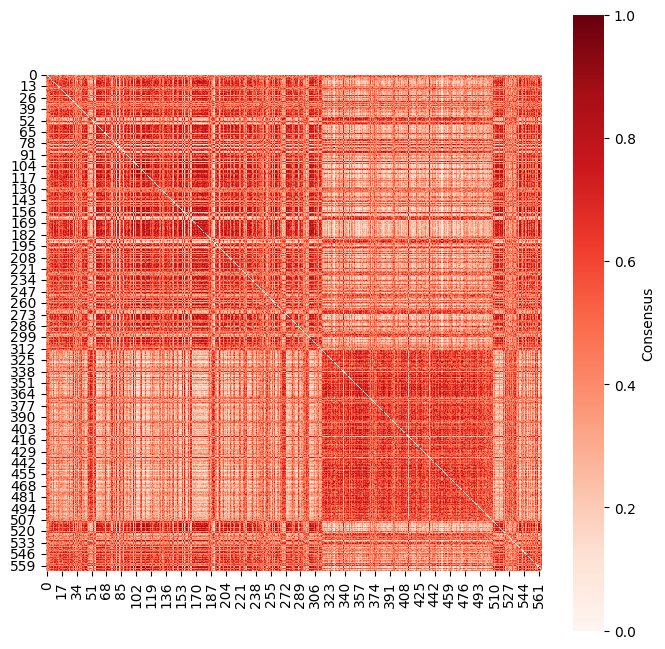

In [13]:
# plot consensus matrix as heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(consensus_matrix, cmap='Reds', square=True, cbar_kws={'label': 'Consensus'})
plt.show()

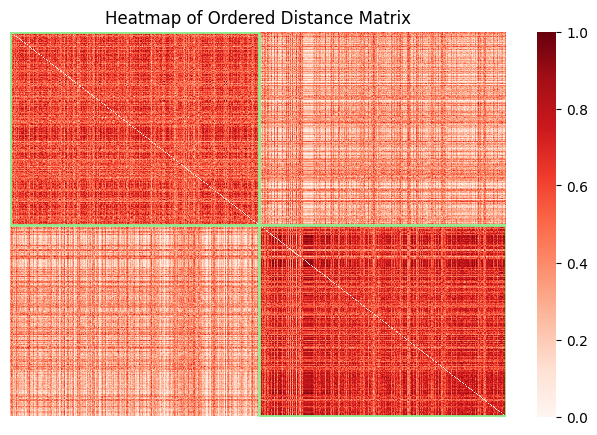

In [14]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform


num_clusters = 2
distance_matrix = 1- consensus_matrix
# set diagonal to 0
np.fill_diagonal(distance_matrix, 0)

# Assuming `distance_matrix` is your full square distance matrix
# Convert to condensed distance matrix for clustering
condensed_distance_matrix = squareform(distance_matrix)

# Perform hierarchical clustering
Z = sch.linkage(condensed_distance_matrix, method='ward')

# Retrieve cluster labels at a given cutoff (not super sure how this works)
clusters = sch.fcluster(Z, t = num_clusters, criterion='maxclust')

# Order the distance matrix by clusters
order = np.argsort(clusters)  # This gives indices that sort the clusters
ordered_distance_matrix = consensus_matrix[order, :][:, order]


# Plot the heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(ordered_distance_matrix, cmap='Reds', xticklabels=False, yticklabels=False)
plt.title('Heatmap of Ordered Distance Matrix')

# Draw squares around each cluster
unique_clusters = np.unique(clusters[order])
boundaries = {cluster: (np.min(np.where(clusters[order] == cluster)), np.max(np.where(clusters[order] == cluster))) for cluster in unique_clusters}
for cluster, (start, end) in boundaries.items():
    plt.hlines([start, end+1], start, end+1, color='lightgreen', lw=2)
    plt.vlines([start, end+1], start, end+1, color='lightgreen', lw=2)

# 2 Dimensional Case

In [15]:
df_gymno_pred

,Bark thickness,Crown diameter,Crown height,Leaf K per mass,Leaf N per mass,Leaf P per mass,Leaf Vcmax per dry mass,Leaf area,Leaf density,Leaf thickness,Root depth,Seed dry mass,Specific leaf area,Stem conduit diameter,Stem diameter,Stomatal conductance,Tree height,Wood density,Leaf area resampled,Wood density resampled
accepted_bin,,,,,,,,,,,,,,,,,,,,
Abies alba,-0.191876,-0.612049,0.090912,-0.286473,0.064711,0.416236,0.308720,-0.017025,0.132083,0.658425,-0.658273,-0.653584,-0.015967,0.118405,-0.809059,0.162788,-0.728766,0.376729,2.616329,0.199558
Abies amabilis,-0.563392,0.151681,0.051243,-0.032071,0.277120,0.946035,0.217701,0.252313,0.361570,0.310727,-0.832156,-0.537614,1.270863,0.336212,-0.266044,-0.044400,0.008008,-0.053479,0.616082,-0.067538
Abies balsamea,-0.885498,-1.362652,-0.742613,-0.118969,0.810527,0.855485,0.968056,0.027757,0.575636,-0.121230,-1.039191,-0.779674,1.159856,1.052960,-1.017147,-0.235083,-1.152036,0.261987,0.985602,0.265477
Abies beshanzuensis,-0.413565,-0.059969,0.083874,-0.013086,0.605072,1.109899,-0.975441,-0.694640,1.876536,0.941044,-0.771270,-0.771100,0.144577,1.773844,-0.279664,-0.369696,0.504454,-3.056323,-0.307394,-3.014823
Abies bracteata,-0.384251,-0.059969,1.149872,-1.168854,0.256324,1.066205,0.520481,-0.569400,1.024808,0.084257,-0.161401,0.241066,0.387022,0.623325,-0.279664,-1.438081,-0.063505,-0.178348,1.878810,-0.371234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Widdringtonia nodiflora,-1.254236,-0.098537,0.941624,0.569273,0.028744,-0.723334,0.375939,-1.360453,-0.383158,1.560937,-0.488868,-0.563879,0.934771,-1.938482,0.948043,-2.165108,-0.795733,-0.177968,-1.938380,-0.183740
Widdringtonia schwarzii,-1.281250,-0.098537,0.941624,0.952677,-1.155379,-0.387171,0.415855,-2.035560,-0.417562,1.591597,-1.211346,-1.131455,-0.044906,-1.410304,0.948043,-0.140388,1.360865,0.540235,-1.138358,0.329285
Widdringtonia wallichii,-0.426297,-0.098537,0.322136,-0.238659,-0.273793,-0.585893,0.427866,-0.113842,0.431009,1.099875,0.169227,-0.481136,-0.338545,-0.740706,0.390965,0.180812,0.060679,0.983732,0.207906,1.043475


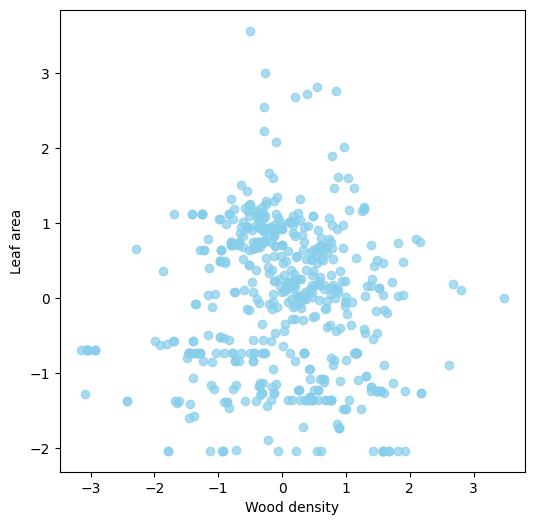

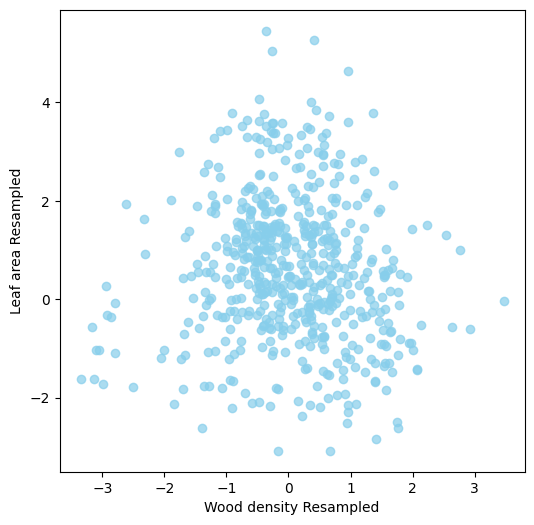

In [16]:
# Define the traits
# trait1, trait2 = 'Leaf area', 'Tree height'
trait1, trait2 = 'Wood density', 'Leaf area'
trait1_resampled, trait2_resampled = f'{trait1} resampled', f'{trait2} resampled'


# Sample random errors for both traits
error_leaf = np.random.choice(error_pred_dist['gymnosperm'][trait1], len(df_gymno_pred), replace=True)
error_crown = np.random.choice(error_pred_dist['gymnosperm'][trait2], len(df_gymno_pred), replace=True)

# Create resampled data columns
df_gymno_pred.loc[:,f'{trait1} resampled'] = df_gymno_pred[trait1] + error_leaf
df_gymno_pred.loc[:,f'{trait2} resampled'] = df_gymno_pred[trait2] + error_crown


#### 2 PLOTS ####
# # Create a figure with subplots for original and resampled data
# fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)  # 1 row, 2 columns

# # Scatter plot of original data
# axs[0].scatter(df_gymno_pred[trait1], df_gymno_pred[trait2], color='skyblue', alpha=0.7)
# axs[0].set_title(f'Original Data: {trait1} vs {trait2}')
# axs[0].set_xlabel(trait1)
# axs[0].set_ylabel(trait2)

# # Scatter plot of resampled data
# axs[1].scatter(df_gymno_pred[f'{trait1} resampled'], df_gymno_pred[f'{trait2} resampled'], color='skyblue', alpha=0.7)
# axs[1].set_title(f'Resampled Data: {trait1} vs {trait2}')
# axs[1].set_xlabel(f'{trait1} Resampled')
# axs[1].set_ylabel(f'{trait2} Resampled')

# # Show the plots
# plt.tight_layout()
# plt.show()


# Plot original data
plt.figure(figsize=(6, 6))  # Set the figure size for the plot
plt.scatter(df_gymno_pred[trait1], df_gymno_pred[trait2], color='skyblue', alpha=0.7)
# plt.title(f'Original Data: {trait1} vs {trait2}')
plt.xlabel(trait1)
plt.ylabel(trait2)
plt.show()  # This shows the first plot and then closes it

# Plot resampled data
plt.figure(figsize=(6, 6))  # Set the figure size for the plot
plt.scatter(df_gymno_pred[trait1_resampled], df_gymno_pred[trait2_resampled], color='skyblue', alpha=0.7)
# plt.title(f'Resampled Data: {trait1} vs {trait2}')
plt.xlabel(f'{trait1} Resampled')
plt.ylabel(f'{trait2} Resampled')
plt.show()  # This shows the second plot

In [17]:
# Assuming df_gymno_pred contains 'Crown height' and 'Crown height resampled' columns
best_n, best_bic = best_gmm_bic(df_gymno_pred[[trait1, trait2]], range(2, 15))
best_n_resampled, best_bic_resampled = best_gmm_bic(df_gymno_pred[[trait1_resampled, trait2_resampled]],
                                                     range(2, 15))

C:\Users\pablo\AppData\Local\Temp\ipykernel_28280\3325333056.py:54: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  a.figure.show()


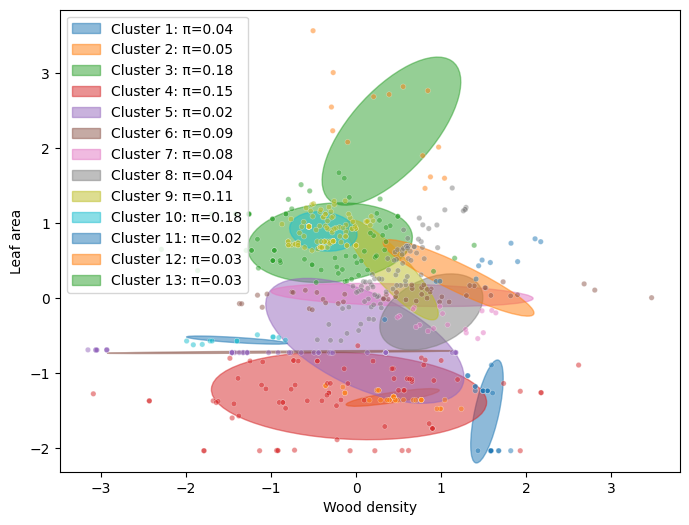

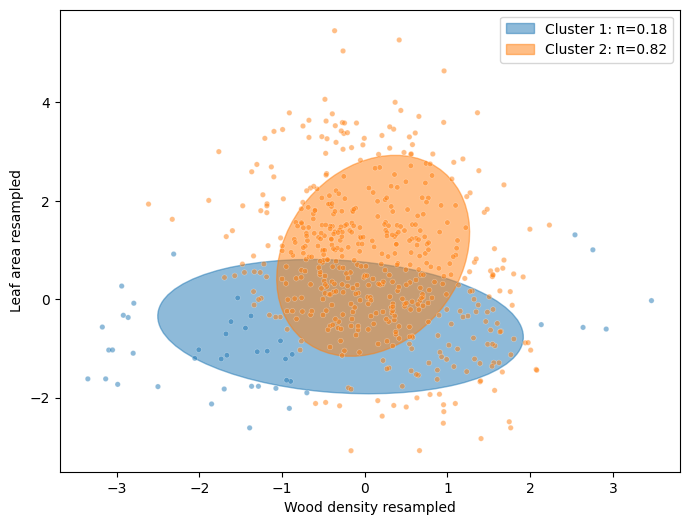

In [18]:
# Boolean to control the display of plots
single_plot = False  # Set this to False to display plots in two separate figures

if single_plot:
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
else:
    ax = [plt.figure(figsize=(8,6)).add_subplot(1, 1, 1) for _ in range(2)]

color_iter = sns.color_palette("tab10", n_colors=best_n) 

# Plot for original data
gmm_original = GaussianMixture(n_components=best_n, random_state=123, n_init=10, init_params='random')
gmm_original.fit(df_gymno_pred[[trait1, trait2]])
gmm_original_labels = gmm_original.predict(df_gymno_pred[[trait1, trait2]])

for ix in range(best_n):  
    v, w = np.linalg.eig(gmm_original.covariances_[ix])
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # Convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ellipse = Ellipse(gmm_original.means_[ix], v[0], v[1], angle=180.0 + angle, color=color_iter[ix],
                      alpha=0.5, label=f'Cluster {ix+1}: π={gmm_original.weights_[ix]:.2f}')
    ellipse.set_clip_box(ax[0].bbox)
    ax[0].add_artist(ellipse)
    ax[0].legend()

sns.scatterplot(x=trait1, y=trait2, data=df_gymno_pred, s=15, alpha=0.5,
                hue=gmm_original_labels, palette='tab10', ax=ax[0], legend=False)

# Plot for resampled data
gmm_resampled = GaussianMixture(n_components=best_n_resampled, random_state=123, n_init=10,
                                init_params='random', tol=1e-6, max_iter=100000)
gmm_resampled.fit(df_gymno_pred[[trait1_resampled, trait2_resampled]])
gmm_resampled_labels = gmm_resampled.predict(df_gymno_pred[[trait1_resampled, trait2_resampled]])

for ix in range(best_n_resampled):  
    v, w = np.linalg.eig(gmm_resampled.covariances_[ix])
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # Convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ellipse = Ellipse(gmm_resampled.means_[ix], v[0], v[1], angle=180.0 + angle, color=color_iter[ix],
                      alpha=0.5, label=f'Cluster {ix+1}: π={gmm_resampled.weights_[ix]:.2f}')
    ellipse.set_clip_box(ax[1].bbox)
    ax[1].add_artist(ellipse)
    ax[1].legend()

sns.scatterplot(x=trait1_resampled, y=trait2_resampled, data=df_gymno_pred, s=15, alpha=0.5,
                hue=gmm_resampled_labels, palette='tab10', ax=ax[1], legend=False)

if single_plot:
    plt.show()
else:
    for a in ax:
        a.figure.show()

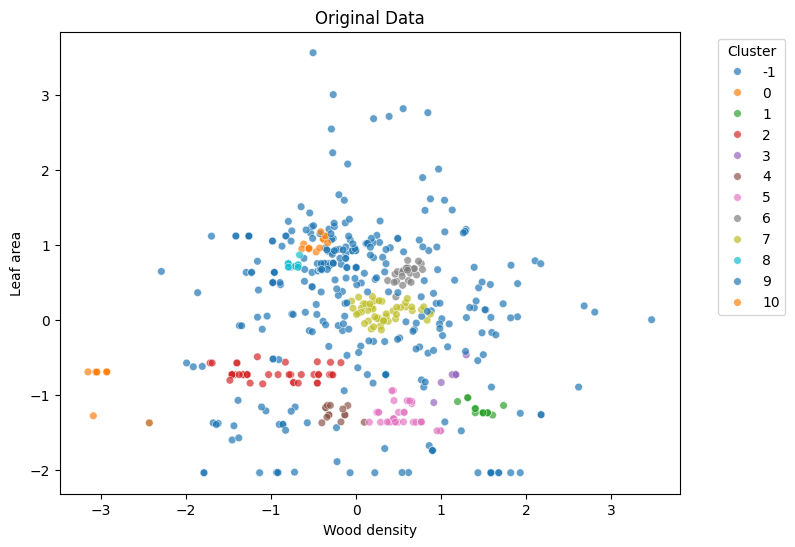

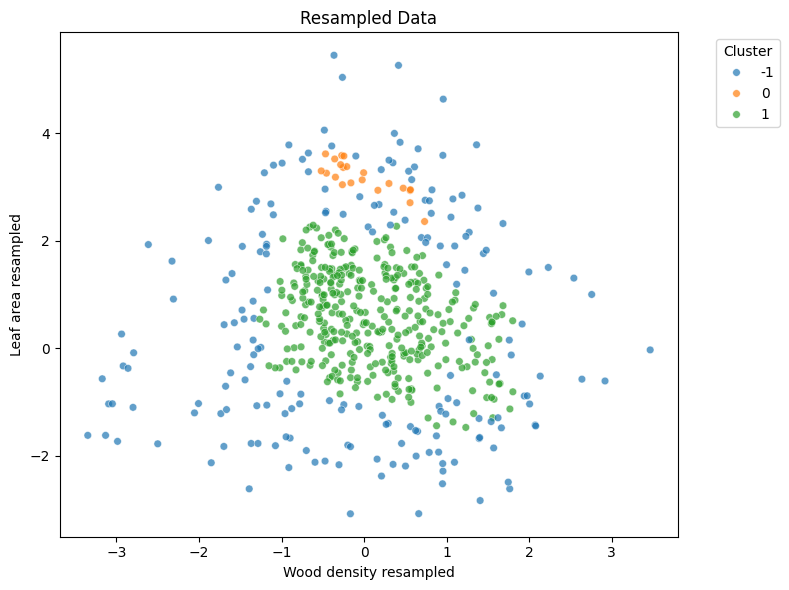

In [19]:
# HDBSCAN
hdbscan_label_original = hdbscan.HDBSCAN(min_cluster_size=10).fit_predict(df_gymno_pred[[trait1, trait2]])
hdbscan_label_resampled = hdbscan.HDBSCAN(min_cluster_size=10).fit_predict(df_gymno_pred[[trait1_resampled, trait2_resampled]])
# DBSCAN
dbscan_label_original = DBSCAN(eps=0.5, min_samples=5).fit_predict(df_gymno_pred[[trait1, trait2]])
dbscan_label_resampled = DBSCAN(eps=0.5, min_samples=5).fit_predict(df_gymno_pred[[trait1_resampled, trait2_resampled]])

# Boolean flag to control display method
single_plot = False  # Change to False for separate figures

if single_plot:
    fig, ax = plt.subplots(1, 2, figsize=(14, 8))
    sns.scatterplot(x=trait1, y=trait2, data=df_gymno_pred, s=30, alpha=0.7,
                    hue=hdbscan_label_original, palette='tab10', ax=ax[0], legend=False)
    sns.scatterplot(x=trait1_resampled, y=trait2_resampled, data=df_gymno_pred, s=30, alpha=0.7,
                    hue=hdbscan_label_resampled, palette='tab10', ax=ax[1], legend=False)
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
else:
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=trait1, y=trait2, data=df_gymno_pred, s=30, alpha=0.7,
                    hue=hdbscan_label_original, palette='tab10')
    plt.title('Original Data')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    plt.figure(figsize=(8,6))
    sns.scatterplot(x=trait1_resampled, y=trait2_resampled, data=df_gymno_pred, s=30, alpha=0.7,
                    hue=hdbscan_label_resampled, palette='tab10')
    plt.title('Resampled Data')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Consensus Matrix

In [20]:
### RESAMPLING APPROACH ####
# trait1 = 'Wood density'
# trait2 = 'Leaf K per mass'
# trait_resampled1 = f'{trait1} resampled'
# trait_resampled2 = f'{trait2} resampled'

consensus_matrix = np.zeros((df_gymno_pred.shape[0], df_gymno_pred.shape[0]))
n_samples = 20

for i in range(n_samples):
    error_list1 = np.array(error_pred_dist['gymnosperm'][trait])
    error_list2 = np.array(error_pred_dist['gymnosperm'][trait2])
    df_gymno_pred.loc[:,trait_resampled1] = resample_trait(df_gymno_pred[trait1], error_list1, 0.05)
    df_gymno_pred.loc[:,trait_resampled2] = resample_trait(df_gymno_pred[trait2], error_list2, 0.05)

    # fit GMM and get labels
    # best_n_resampled, best_bic_resampled = best_gmm_bic(df_gymno_pred[[trait_resampled1,trait_resampled2]],
    #                                                        range(2, 5))
    
    gmm_resampled = GaussianMixture(n_components=51, random_state=123, n_init=1)
    gmm_resampled.fit(df_gymno_pred[[trait_resampled1,trait_resampled2]])
    clusters_resampled = gmm_resampled.predict(df_gymno_pred[[trait_resampled1,trait_resampled2]])
    for j in range(df_gymno_pred.shape[0]):
        for k in range(j+1, df_gymno_pred.shape[0]):
            if clusters_resampled[j] == clusters_resampled[k]:
                consensus_matrix[j, k] += 1
                consensus_matrix[k, j] += 1

    # # fit HDBSCAN and get labels
    # hdbscan_resampled = hdbscan.HDBSCAN(min_cluster_size=5)
    # clusters_resampled = hdbscan_resampled.fit_predict(np.array(df_gymno_pred[[trait_resampled1, trait_resampled2]]))
    # # grab index that are not -1
    # cluster_index = np.where(clusters_resampled != -1)[0]
    # # add to consensus matrix
    # for j in cluster_index:
    #     for k in cluster_index:
    #         if clusters_resampled[j] == clusters_resampled[k]:
    #             consensus_matrix[j, k] += 1

# normalize consensus matrix
consensus_matrix = consensus_matrix / n_samples

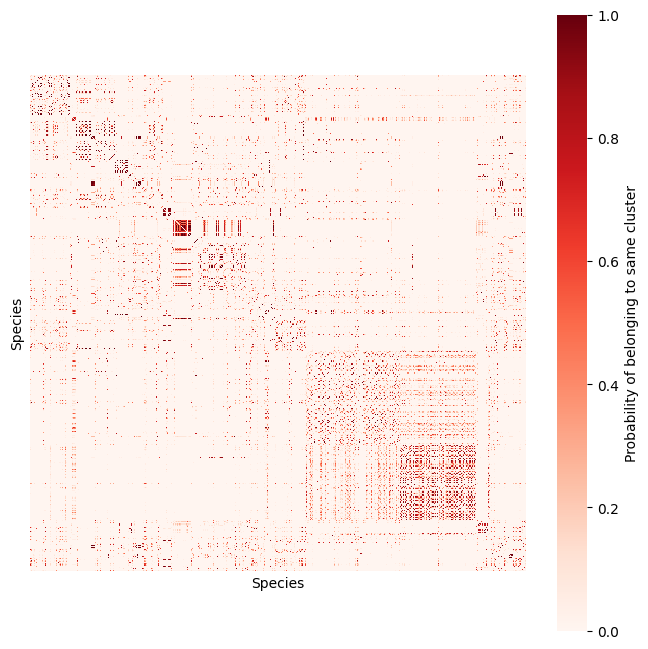

In [21]:

# plot consensus matrix as heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(consensus_matrix, cmap='Reds', square=True, 
            cbar_kws={'label': 'Probability of belonging to same cluster'})
# x axis name
plt.xlabel('Species')
plt.ylabel('Species')
# no ticks
plt.xticks([])
plt.yticks([])

plt.show()

Silhouette score: 0.4013263696031683


Text(119.44444444444444, 0.5, 'Species')

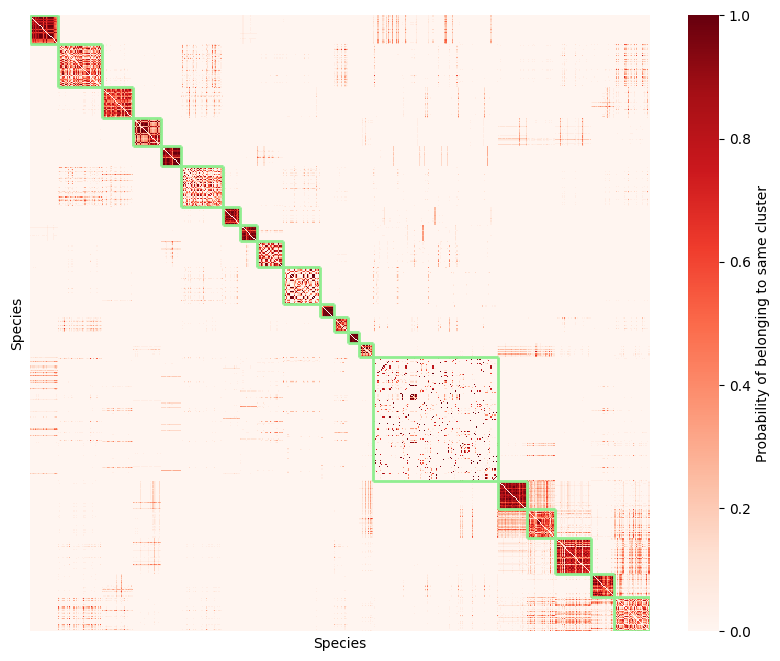

In [22]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from sklearn import metrics


num_clusters = 20
distance_matrix = 1- consensus_matrix
# set diagonal to 0
np.fill_diagonal(distance_matrix, 0)

# Assuming `distance_matrix` is your full square distance matrix
# Convert to condensed distance matrix for clustering
condensed_distance_matrix = squareform(distance_matrix)

# Perform hierarchical clustering
Z = sch.linkage(condensed_distance_matrix, method='ward')

# Retrieve cluster labels at a given cutoff (not super sure how this works)
consensus_labels = sch.fcluster(Z, t = num_clusters, criterion='maxclust')
# get silhouette score
silhouette_score = metrics.silhouette_score(distance_matrix, consensus_labels, metric='precomputed')
print(f'Silhouette score: {silhouette_score}')

# Order the distance matrix by clusters
order = np.argsort(consensus_labels)  # This gives indices that sort the clusters
ordered_distance_matrix = consensus_matrix[order, :][:, order]


# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(ordered_distance_matrix, cmap='Reds', xticklabels=False, yticklabels=False,
            cbar_kws={'label': 'Probability of belonging to same cluster'})
# plt.title('Heatmap of Ordered Distance Matrix')

# Draw squares around each cluster
unique_clusters = np.unique(consensus_labels[order])
boundaries = {cluster: (np.min(np.where(consensus_labels[order] == cluster)), np.max(np.where(consensus_labels[order] == cluster))) for cluster in unique_clusters}
for cluster, (start, end) in boundaries.items():
    plt.hlines([start, end+1], start, end+1, color='lightgreen', lw=2)
    plt.vlines([start, end+1], start, end+1, color='lightgreen', lw=2)
# cbar label
# plt.colorbar.set_label('Probability of belonging to same cluster')
# x and y axis label
plt.xlabel('Species')
plt.ylabel('Species')

Figure Heatmap resumed

In [23]:
num_clusters = 20
condensed_distance_matrix = squareform(distance_matrix)
# Perform hierarchical clustering
Z = sch.linkage(condensed_distance_matrix, method='ward')
# Retrieve cluster labels at a given cutoff (not super sure how this works)
consensus_labels = sch.fcluster(Z, t = num_clusters, criterion='maxclust')


consensus_summary_matrix = np.zeros((num_clusters, num_clusters))
cluster_sizes = np.zeros(num_clusters)

for c in range(1, num_clusters+1):
    index_c = np.where(consensus_labels == c)[0]
    cluster_size = len(index_c)
    cluster_sizes[c-1] = cluster_size
    matrix_c = consensus_matrix[index_c, :][:, index_c]
    avg_consensus_c = matrix_c.sum() / (len(index_c)**2 - len(index_c))  # all except diagonal (elements repeat)
    # print(f'Average consensus {c}: {avg_consensus_c}')
    consensus_summary_matrix[c-1, c-1] = avg_consensus_c
    for c_2 in range(c+1, num_clusters+1):
        # compute average consensus between clusters
        index_c_2 = np.where(consensus_labels == c_2)[0]
        matrix_c1_c2 = consensus_matrix[index_c, :][:, index_c_2]
        avg_consensus_c1_c2 = matrix_c1_c2.sum() / (len(index_c) * len(index_c_2))
        consensus_summary_matrix[c-1, c_2-1] = avg_consensus_c1_c2
        consensus_summary_matrix[c_2-1, c-1] = avg_consensus_c1_c2
        # print(f'Average consensus {c}-{c_2} v2: {avg_consensus_c1_c2}')

# Reorder matrix based on cluster sizes
sorted_indices = np.argsort(-cluster_sizes)  # Sort indices by cluster size in descending order
consensus_summary_matrix = consensus_summary_matrix[sorted_indices, :][:, sorted_indices]
cluster_sizes = cluster_sizes[sorted_indices]



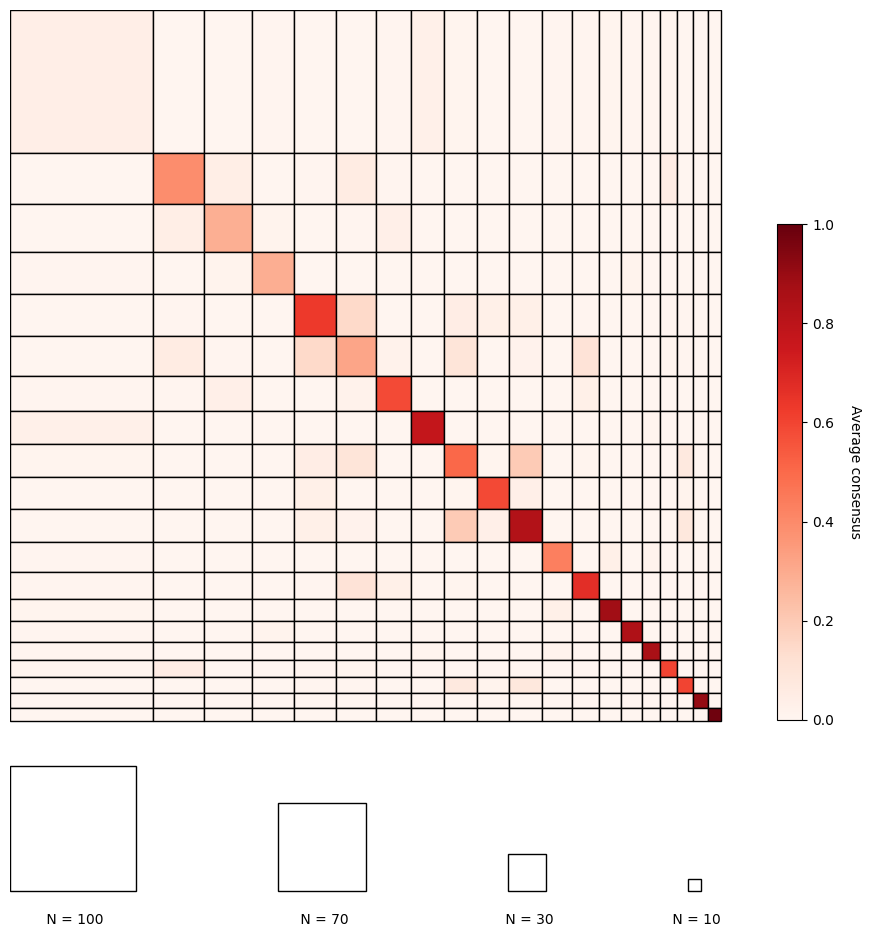

In [31]:
# Sort clusters by size
sorted_indices = np.argsort(-cluster_sizes)
sorted_matrix = consensus_summary_matrix[sorted_indices, :][:, sorted_indices]
sorted_cluster_sizes = cluster_sizes[sorted_indices]


# Normalize cluster sizes to get proportions
total_size = sum(sorted_cluster_sizes)
normalized_sizes = sorted_cluster_sizes / total_size

# Create custom plot
fig, ax = plt.subplots(figsize=(16, 12))
current_x = 0

for i in range(num_clusters):
    current_y = 0
    for j in range(num_clusters):
        width = normalized_sizes[i]   # Scaling factor for visual clarity
        height = normalized_sizes[j] # Scaling factor for visual clarity
        color = plt.cm.Reds(sorted_matrix[i, j])
        rect = plt.Rectangle((current_x, current_y), width, height, facecolor=color, edgecolor='black')
        ax.add_patch(rect)
        current_y += height
    current_x += width


# Remove plot borders
ax.axis('off')
# Titles and labels
ax.set_xlim(0, current_x+0.01)
ax.set_ylim(0, current_y+0.3)
ax.invert_yaxis()
plt.xlabel('Cluster')
plt.ylabel('Cluster')
plt.gca().set_aspect('equal', adjustable='box')

# Add color bar
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.02, pad=0.04)
cbar.set_label('Average consensus', rotation=270, labelpad=20)

# remove ticks
plt.xticks([])
plt.yticks([])



#### LEGEND SQUARES ###
# Define the specific sizes you want for the legend
specific_sizes = [100,70,30,10]  # Example sizes in terms of species

# Calculate the corresponding normalized sizes
total_size = sum(sorted_cluster_sizes)
normalized_specific_sizes = [size / total_size for size in specific_sizes]

starting_x = 0
y_start = current_y + 0.24  # Start y position for the legend
# Draw each specified square and annotate
for i, size in enumerate(normalized_specific_sizes):
    rect = plt.Rectangle((starting_x, y_start - size), size, size, facecolor='white', edgecolor='black')
    ax.add_patch(rect)
    ax.text(starting_x + size / 2, y_start + 0.03, f' N = {specific_sizes[i]}', ha='center', va='top')
    starting_x += size + 0.2  # Increment x position



plt.savefig('test_matrix_2.png')
plt.show()


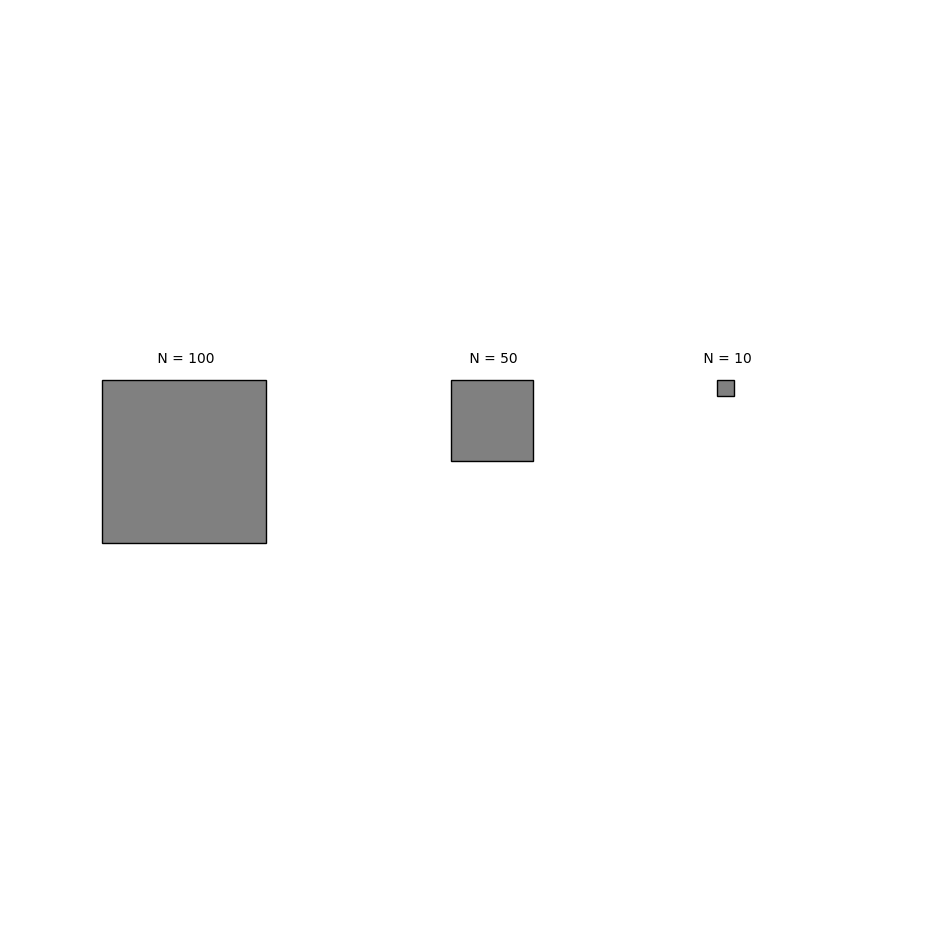

In [25]:

# Define the specific sizes you want for the legend
specific_sizes = [100,50,10]  # Example sizes in terms of species

# Calculate the corresponding normalized sizes
total_size = sum(sorted_cluster_sizes)
normalized_specific_sizes = [size / total_size for size in specific_sizes]

# Create a figure for the legend
fig_legend, ax_legend = plt.subplots(figsize=(16,12))
ax_legend.set_xlim(0, 1)
ax_legend.set_ylim(0, 1)
starting_x = 0.1  # Starting x position for drawing squares
y_start = 0.6  # Upper starting point for all squares

# Draw each specified square and annotate
for i, size in enumerate(normalized_specific_sizes):
    rect = plt.Rectangle((starting_x, y_start - size), size, size, facecolor='grey', edgecolor='black')
    ax_legend.add_patch(rect)
    ax_legend.text(starting_x + size / 2, y_start + 0.03, f' N = {specific_sizes[i]}', ha='center', va='top')
    starting_x += size + 0.2  # Increment x position

# Configure plot aesthetics
ax_legend.set_aspect('equal', adjustable='box')
plt.axis('off')  # Turn off axis
plt.savefig('test_matrix.png', bbox_inches='tight')
plt.show()

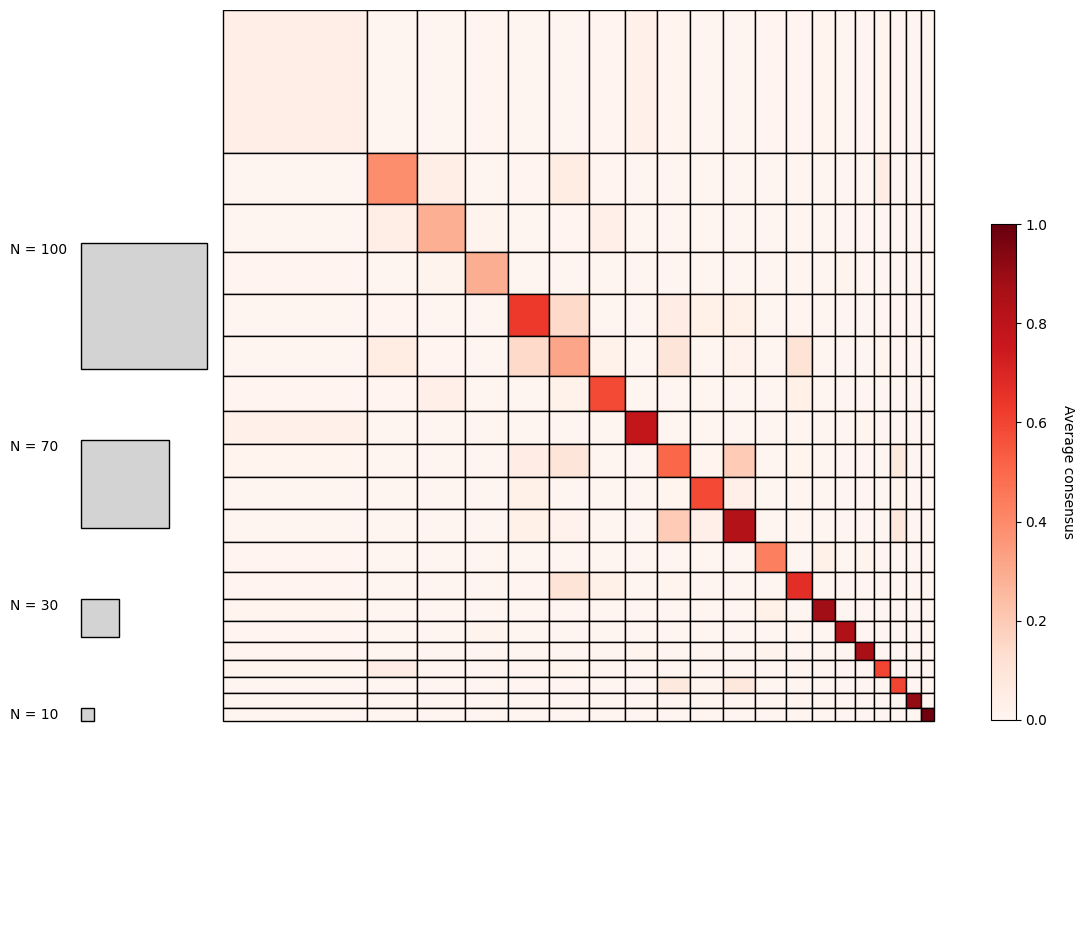

In [60]:
# Create custom plot
fig, ax = plt.subplots(figsize=(16, 12))
current_x = 0

for i in range(num_clusters):
    current_y = 0
    for j in range(num_clusters):
        width = normalized_sizes[i]   # Scaling factor for visual clarity
        height = normalized_sizes[j] # Scaling factor for visual clarity
        color = plt.cm.Reds(sorted_matrix[i, j])
        rect = plt.Rectangle((current_x, current_y), width, height, facecolor=color, edgecolor='black')
        ax.add_patch(rect)
        current_y += height
    current_x += width

# Remove plot borders
ax.axis('off')
# Titles and labels
ax.set_xlim(-0.25, current_x + 0.01)
ax.set_ylim(0, current_y + 0.3)
ax.invert_yaxis()
plt.xlabel('Cluster')
plt.ylabel('Cluster')
plt.gca().set_aspect('equal', adjustable='box')

# Add color bar
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.02, pad=0.04)
cbar.set_label('Average consensus', rotation=270, labelpad=20)

# Remove ticks
plt.xticks([])
plt.yticks([])

#### LEGEND SQUARES (Left) ###
# Define the specific sizes you want for the legend
specific_sizes = [10, 30, 70, 100]  # Example sizes in terms of species

# Calculate the corresponding normalized sizes
normalized_specific_sizes = [size / total_size for size in specific_sizes]

# Adjusted positions for the legend squares
x_start = -0.25  # Move further to the left
starting_y = 1  # Start closer to the top

# Draw each specified square and annotate
for i, size in enumerate(normalized_specific_sizes):
    rect = plt.Rectangle((x_start+0.05, starting_y - size), size, size, facecolor='lightgrey', edgecolor='black')
    ax.add_patch(rect)
    ax.text(x_start - 0.05, starting_y - size + .015, f'N = {specific_sizes[i]}', 
            ha='left')
    starting_y -= size + 0.1  # Increment y position with a bit more spacing

plt.savefig('test_matrix_2.png')
plt.show()

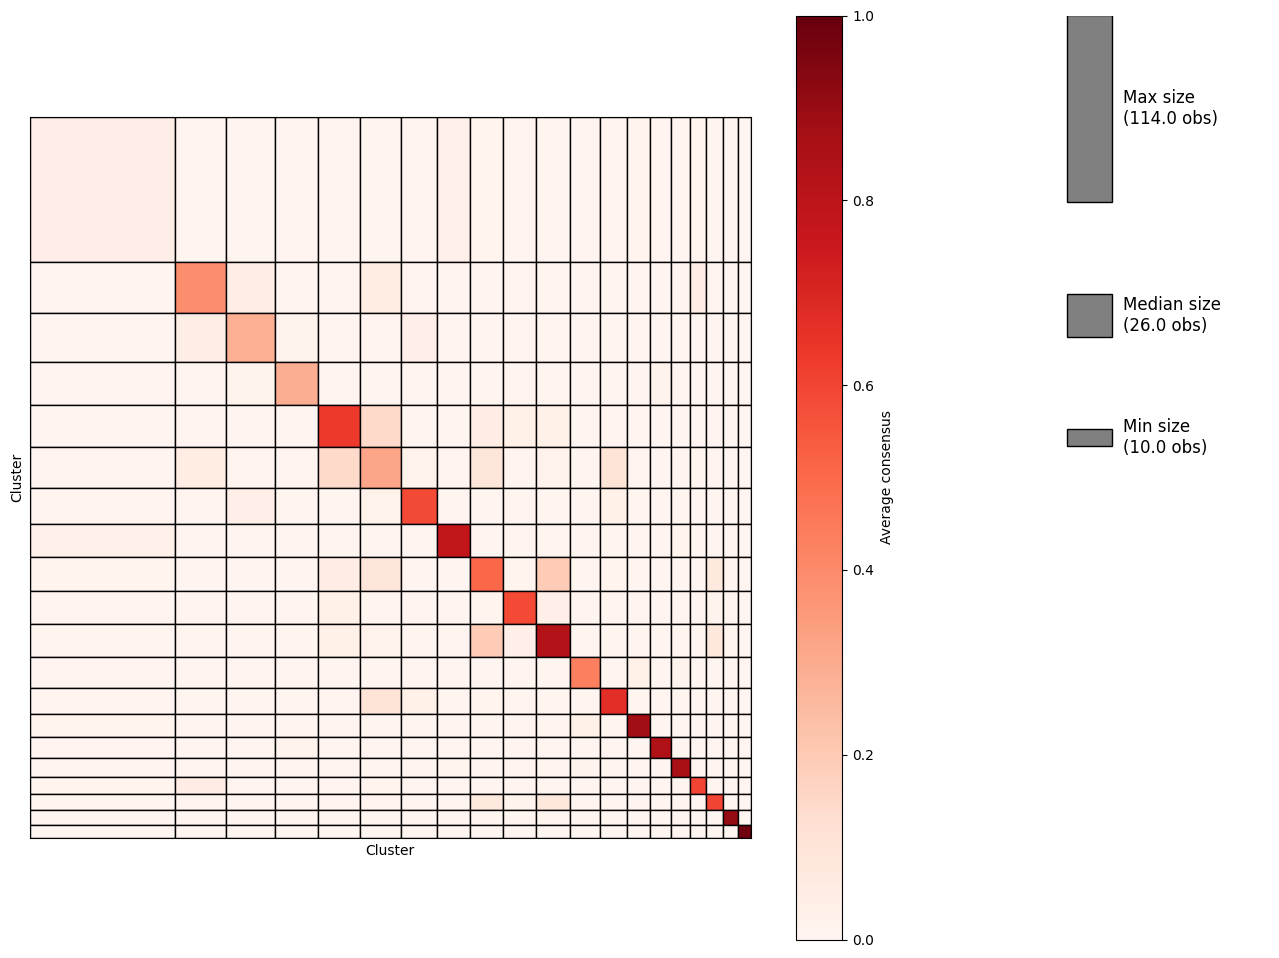

In [26]:
# Sort clusters by size
sorted_indices = np.argsort(-cluster_sizes)
sorted_matrix = consensus_summary_matrix[sorted_indices, :][:, sorted_indices]
sorted_cluster_sizes = cluster_sizes[sorted_indices]

# Normalize cluster sizes to get proportions
total_size = sum(sorted_cluster_sizes)
normalized_sizes = sorted_cluster_sizes / total_size

# Create custom plot
fig, (ax, ax_legend) = plt.subplots(1, 2, figsize=(16, 12), gridspec_kw={'width_ratios': [4, 1]})
current_x = 0

for i in range(num_clusters):
    current_y = 0
    for j in range(num_clusters):
        width = normalized_sizes[i]   # Scaling factor for visual clarity
        height = normalized_sizes[j]  # Scaling factor for visual clarity
        color = plt.cm.Reds(sorted_matrix[i, j])
        rect = plt.Rectangle((current_x, current_y), width, height, facecolor=color, edgecolor='black')
        ax.add_patch(rect)
        current_y += height
    current_x += width

# Titles and labels for the heatmap
ax.set_xlim(0, current_x)
ax.set_ylim(0, current_y)
ax.invert_yaxis()
ax.set_xlabel('Cluster')
ax.set_ylabel('Cluster')
ax.set_aspect('equal', adjustable='box')

# Add color bar to the heatmap
norm = plt.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Average consensus')

# remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Create the legend subplot
ax_legend.axis('off')
legend_y = 1.0  # Starting point for the legend squares

# Determine sizes and labels for the legend
sizes_to_display = [max(sorted_cluster_sizes), np.median(sorted_cluster_sizes), min(sorted_cluster_sizes)]
size_labels = ['Max size', 'Median size', 'Min size']

for size, label in zip(sizes_to_display, size_labels):
    normalized_size = size / total_size
    rect = plt.Rectangle((0.1, legend_y - normalized_size), 0.2, normalized_size, facecolor='gray', edgecolor='black', transform=ax_legend.transAxes)
    ax_legend.add_patch(rect)
    ax_legend.text(0.35, legend_y - normalized_size / 2, f'{label}\n({size} obs)', 
                   verticalalignment='center', fontsize=12, transform=ax_legend.transAxes)
    legend_y -= normalized_size + 0.1  # Move to the next position

plt.show()


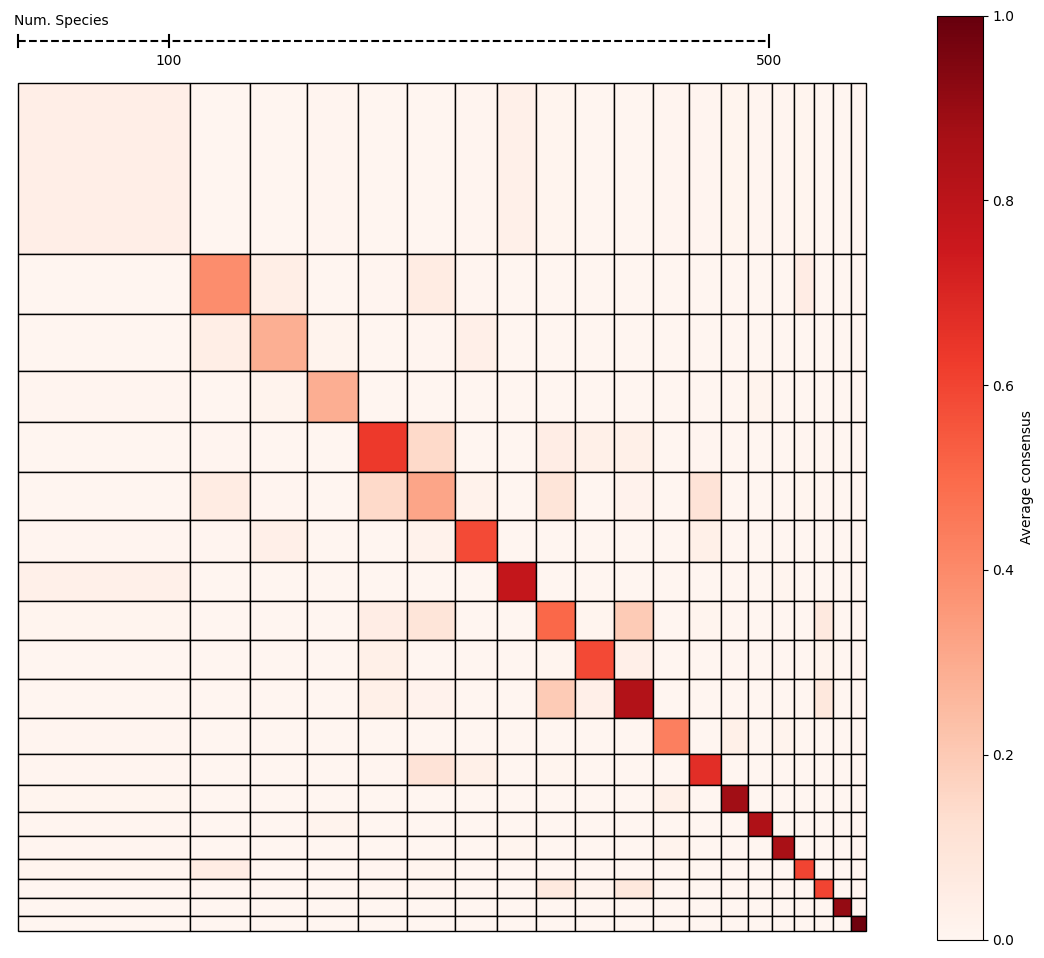

In [27]:
def plot_consensus_matrix(consensus_summary_matrix, cluster_sizes, scale_small, scale_big):
    # Sort clusters by size
    num_clusters = len(cluster_sizes)
    sorted_indices = np.argsort(-cluster_sizes)
    sorted_matrix = consensus_summary_matrix[sorted_indices, :][:, sorted_indices]
    sorted_cluster_sizes = cluster_sizes[sorted_indices]

    # Normalize cluster sizes to get proportions
    total_size = sum(sorted_cluster_sizes)
    normalized_sizes = sorted_cluster_sizes / total_size

    # Create custom plot
    fig, ax = plt.subplots(figsize=(16, 12))

    # Remove plot borders
    ax.axis('off')

    current_x = 0.01
    for i in range(num_clusters):
        current_y = 0.08
        for j in range(num_clusters):
            width = normalized_sizes[i]   # Scaling factor for visual clarity
            height = normalized_sizes[j]  # Scaling factor for visual clarity
            # height = 0.05
            color = plt.cm.Reds(sorted_matrix[i, j])
            rect = plt.Rectangle((current_x, current_y), width, height, facecolor=color, edgecolor='black')
            ax.add_patch(rect)
            current_y += height
        current_x += width

    # Titles and labels
    ax.set_xlim(0, current_x + 0.01)
    ax.set_ylim(0, current_y + 0.01)
    ax.invert_yaxis()
    plt.xlabel('Cluster')
    plt.ylabel('Cluster')
    plt.gca().set_aspect('equal', adjustable='box')

    # Add color bar
    norm = plt.Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Average consensus')

    # Remove ticks
    plt.xticks([])
    plt.yticks([])

    # Calculate scales
    scale_small_species = scale_small / total_size
    scale_big_species = scale_big / total_size

    # Plot the reference scale line
    ax.plot([0.01, scale_big_species + 0.01], [0.03, 0.03], color='black', linewidth=1.5, linestyle='--')

    # Add legend on top of the line
    ax.text(0.06, 0.015, 'Num. Species', ha='center', va='bottom')

    # Add ticks and labels for the scales
    tick_length = 0.007
    ax.plot([0.01, 0.01], [0.03 - tick_length, 0.03 + tick_length], color='black', linewidth=1.5)
    ax.plot([scale_small_species + 0.01, scale_small_species + 0.01], [0.03 - tick_length, 0.03 + tick_length], color='black', linewidth=1.5)
    ax.text(scale_small_species + 0.01, 0.045, str(scale_small), ha='center', va='top')

    ax.plot([scale_big_species + 0.01, scale_big_species + 0.01], [0.03 - tick_length, 0.03 + tick_length], color='black', linewidth=1.5)
    ax.text(scale_big_species + 0.01, 0.045, str(scale_big), ha='center', va='top')

    plt.show()

plot_consensus_matrix(consensus_summary_matrix, cluster_sizes, 100, 500)

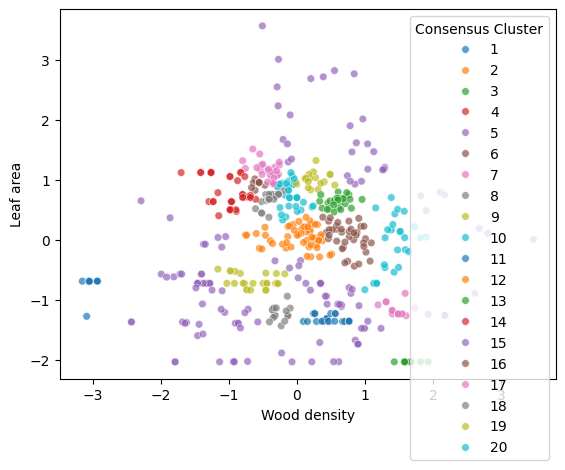

In [28]:
# create figure to show both scatter plots with HDBSCAN
# fig, ax = plt.subplots(1, 2, figsize=(14, 8))

# Original data
sns.scatterplot(x=trait1, y = trait2, data=df_gymno_pred, s=30, alpha=0.7,
                hue=consensus_labels, palette='tab10', legend=True)
# legend name
plt.legend(title='Consensus Cluster')

# # Resampled data
# sns.scatterplot(x=trait1_resampled, y = trait2_resampled, data=df_gymno_pred, s=30, alpha=0.7,
#                 hue = hdbscan_label_resampled, palette='tab10', ax=ax[1], legend=True)

# plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
